In [12]:
import numpy as np
import matplotlib.pyplot as plt
from calcwf import gen_wf, chirp2total, total2chirp, overlap_cplx_wfs, get_h

In [2]:
sample_rate = 4096

# e^2 against chirp mass plots

In [24]:
# Calculates matches to a fiducial waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match(e_vals, chirp_vals, fiducials, f_low, fid_wf, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h2':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    if fid_wf == 'get_h':
        _, h1, h2, _, _ = get_h([1,1], f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)
    elif fid_wf == 'TEOB':
        h = gen_wf(f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)
    else:
        raise Exception('fid_wf not recognised')

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h2'].append([])
        if fid_wf == 'TEOB':
            matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:
            
            # Create waveform at this grid point
            _, s1, s2, _, _ = get_h([1,1], f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)

            # Calculate matches
            if fid_wf == 'get_h':
                match_h1 = overlap_cplx_wfs(h1, s1, f_low)
                match_h2 = overlap_cplx_wfs(h2, s2, f_low)
            elif fid_wf == 'TEOB':
                match_h1 = overlap_cplx_wfs(h, s1, f_low)
                match_h2 = overlap_cplx_wfs(h, s2, f_low)
                match_quad = np.sqrt(match_h1**2+match_h2**2)
                matches['quad'][-1].append(match_quad)
            matches['h1'][-1].append(abs(match_h1))
            matches['h2'][-1].append(abs(match_h2))

            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [34]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot(e_vals, chirp_vals, fiducials, matches, vmins=None, vmaxs=None):

    # Default vmins and vmaxs value depends on number of plots
    if vmins == None:
        vmins = [0.7]*len(matches.keys())
    if vmaxs == None:
        vmaxs = [1]*len(matches.keys())
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Make contour plot for each match
    for i, key in enumerate(matches.keys()):
        plt.contourf(chirp_vals, e2_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend='min')
        plt.colorbar(label='match')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

In [8]:
total2chirp(60, 2)

24.33457367572823

In [9]:
chirp2total(24, 2)

59.17506586262013

In [4]:
e_vals_1 = np.linspace(0, 0.2, 11)[1:]
chirp_vals_1 = np.linspace(23, 25, 11)
dataslot_1 = ecc_chirp_match(e_vals_1, chirp_vals_1, [0.1, 24, 2], 10, 'get_h')

110 done out of 110

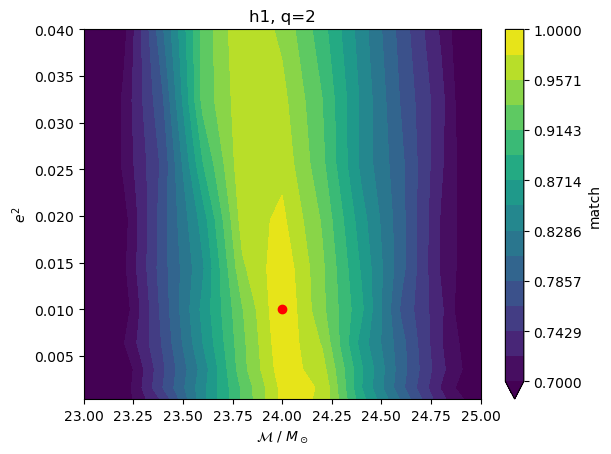

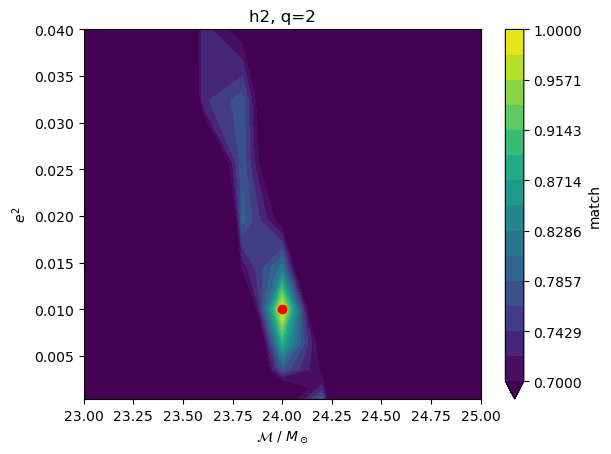

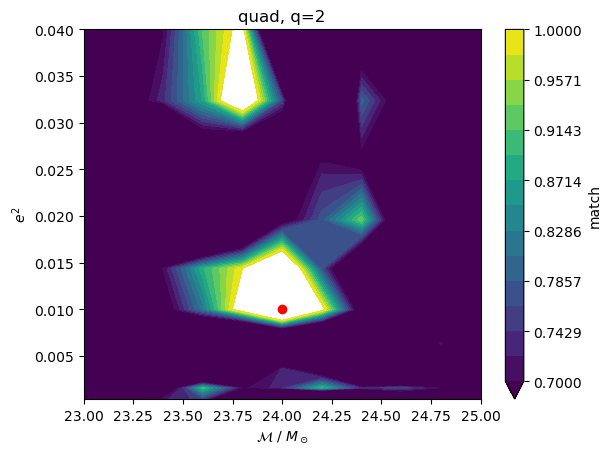

In [30]:
ecc_chirp_plot(e_vals_1, chirp_vals_1, [0.1, 24, 2], dataslot_1)

In [25]:
e_vals_2 = e_vals_1
chirp_vals_2 = chirp_vals_1
dataslot_2 = ecc_chirp_match(e_vals_2, chirp_vals_2, [0.1, 24, 2], 10, 'TEOB')

110 done out of 110

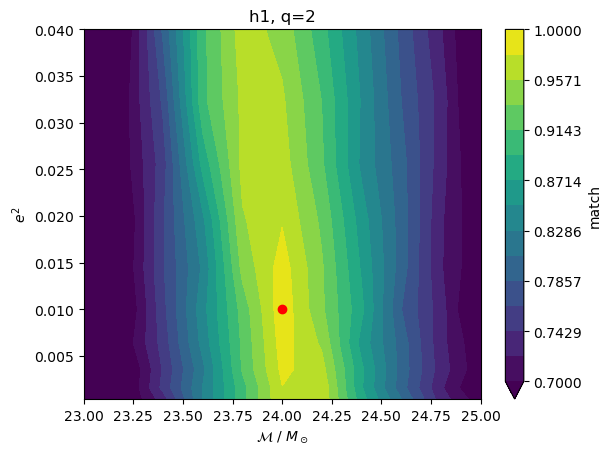

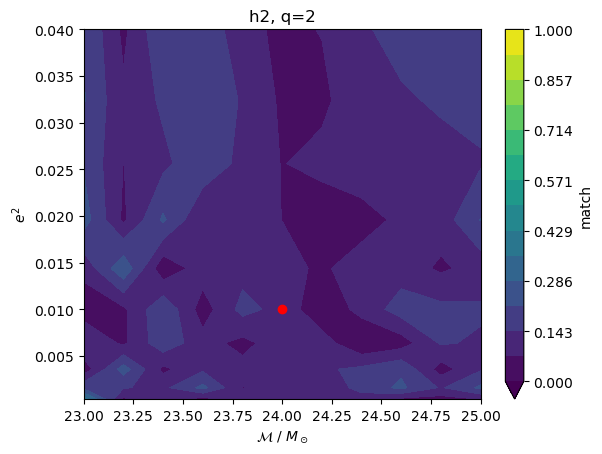

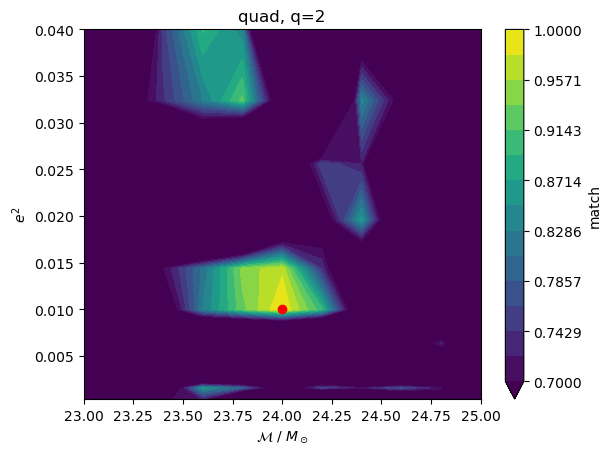

In [35]:
ecc_chirp_plot(e_vals_2, chirp_vals_2, [0.1, 24, 2], dataslot_2, vmins=[0.7,0,0.7])